In [41]:
import torch
torch.cuda.empty_cache()
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dev

device(type='cuda')

In [42]:
PATH = "unet_best.pt"
import unet
import torch
model = unet.UNet(1,2)
model.load_state_dict(torch.load(PATH,map_location=dev))


<All keys matched successfully>

In [43]:
import pandas as pd

dataset = pd.read_json("./data/dataset.json")
dataset = dataset.sample(frac=1,random_state=0)[:] # shuffle
split = int(len(dataset) * 0.9)
train_df = dataset[1:split].copy()
test_df =  dataset[split:].copy()
df = test_df


In [44]:
from torchvision.transforms import transforms, Lambda
transform_test = transforms.Compose([
                                      transforms.ToTensor(),  
                                      transforms.Resize((256,256),antialias=True),
                                     # transforms.Normalize(mean=[0.485], std=[0.229]) #Normalize all the images
                               ])

## Visual examination

0.99999857 7.662104e-20


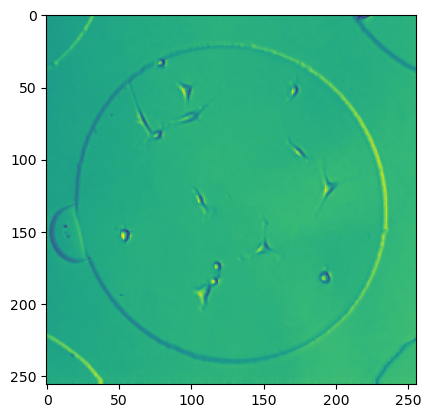

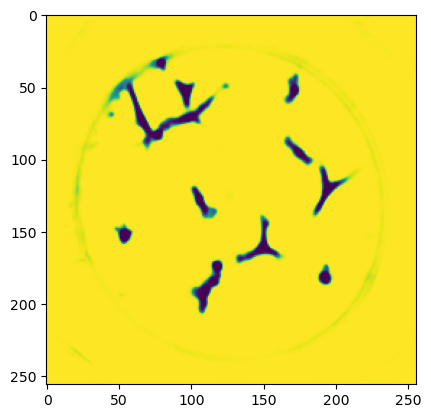

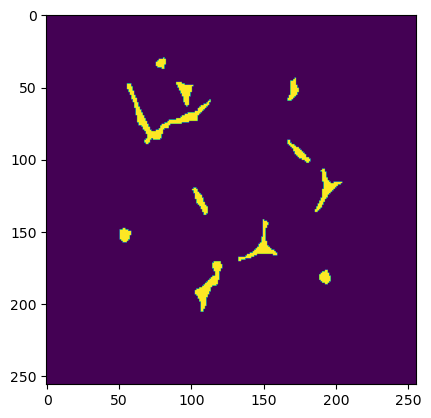

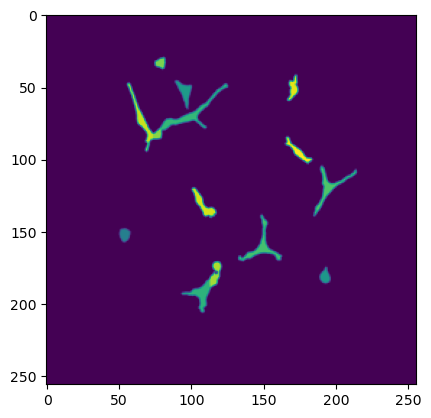

In [45]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

index = 0
img = Image.open(df["image_path"].iloc[index])
anot = transform_test(Image.open(df["seg_path"].iloc[index])).detach().numpy()
img = transform_test(img)
img = img[None,:]

model.eval()
with torch.no_grad():
    res = model(img)
    res = torch.sigmoid(res) 
    res = res.detach().numpy()

bg, fg = res[0]   
print(np.max(fg),np.min(fg))
plt.imshow(img[0][0])
plt.show()
plt.imshow(bg)
plt.show()

th = fg>0.8
plt.imshow(th)
plt.show()

plt.imshow(anot[0])
plt.show()



In [46]:
from tqdm.notebook import tqdm
from torchmetrics import JaccardIndex




def Evaluate(dataset, model,th):
    scores = []
    model.eval()
    jaccard = JaccardIndex(num_classes=2,task="binary")
    for i in tqdm(range(0,len(dataset))):
        img = Image.open(df["image_path"].iloc[i])
        anot = transform_test(Image.open(df["seg_path"].iloc[i]))[0]>0
        img = transform_test(img)
        
        with torch.no_grad():
            res = model(img[None,:].to(dev))
            res = torch.sigmoid(res) 
            res = res.to("cpu")

        bg, fg = res[0] 
        rec_th = fg>th
        
        intersection = torch.logical_and(rec_th, anot)
        union = torch.logical_or(rec_th, anot)
        iou_score = torch.sum(intersection) / torch.sum(union)
        #iou_score = jaccard(rec_th,anot) 
        scores.append(iou_score)
        

    return np.array(scores)

In [47]:
model.to(dev)
np.mean(Evaluate(df,model,0.5))

  0%|          | 0/276 [00:00<?, ?it/s]

0.73994666

# Evaluation
more info in the summary document

In [48]:
from skimage import color, io
from skimage.transform import rescale, resize
from skimage.morphology import label
import cv2 as cv


def EvaluatePR(dataset, model,th,iou_th):
    """Compute tp, fp fn for the dataset"""
    scores = []
    model.eval()
    jaccard = JaccardIndex(num_classes=2,task="binary")
    ctp, cfp, cfn = 0,0,0
    for i in range(0,len(dataset)):
        img = Image.open(df["image_path"].iloc[i])
        anot = io.imread(df["seg_path"].iloc[i]).astype(np.int32)
        anot = cv.resize(np.int32(anot),(256,256),fx=0, fy=0, interpolation = cv.INTER_NEAREST)
        img = transform_test(img)
        
        with torch.no_grad():
            res = model(img[None,:].to(dev))
            res = torch.sigmoid(res) 
            res = res.to("cpu")

        bg, fg = res[0] 
        rec_th = fg>th
        instances = label(rec_th)
        tp, fp, fn = GetStats(instances,anot,iou_th)
        ctp += tp
        cfp += fp
        cfn += fn

    return ctp, cfp, cfn

def GetStats(instances, anot, iou_th):
    """Go through every connected componnet and compute tp, fp, fn"""
    tp = 0
    fp = 0
    fn = 0

    notused = np.ones(np.max(instances))
    for l in range(1,np.max(anot)+1):
        best_score = 0.0
        best_label = 0
        if np.max(anot == l) == False:  # some annotation labels are just empty
            continue
        for dl in range(1,np.max(instances)+1):
            a = instances == dl  # get component from the detection
            b = anot == l # get component from 
            intersection = np.logical_and(a, b)
            union = np.logical_or(a, b)

             # IoU
            iou_score = np.sum(intersection) / np.sum(union)
            if iou_score > best_score:
                best_score =iou_score
                best_label = dl
    # print(iou_score)
        if best_score > iou_th:
            tp +=1
            notused[best_label-1] = 0
        else:
            fn += 1
    fp = np.sum(notused) # componnets not in the annotation are false negatives
    return tp, fp, fn

tprec = []
trecall = []
for ioth in tqdm(np.linspace(0,1,5)):
    tp, fp, fn = EvaluatePR(df,model,0.5,ioth)
    print(tp,fp,fn)
    prec = tp / (tp+fp)
    recall = tp / (tp + fn)
    print(prec, recall, ioth )
    tprec.append(prec)
    trecall.append(recall)


  0%|          | 0/5 [00:00<?, ?it/s]

1243 48.0 13
0.9628195197521301 0.9896496815286624 0.0
1133 57.0 123
0.9521008403361344 0.9020700636942676 0.25
842 265.0 414
0.7606142728093948 0.6703821656050956 0.5
78 1029.0 1178
0.07046070460704607 0.06210191082802548 0.75
0 1107.0 1256
0.0 0.0 1.0


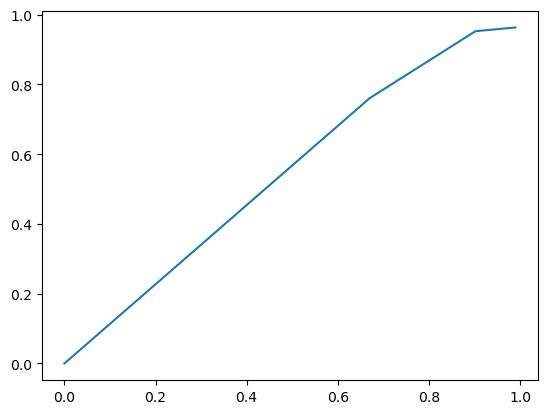

In [49]:

xs, ys = zip(*sorted(zip(trecall, tprec)))


plt.plot(xs,ys)